In [29]:
#Calcular pressão de saturação da acetona pura com PREOS

#Definição das constantes físicas e da EOS

import numpy as np
import matplotlib.pyplot as plt

T = 303
R = 8.3144598 
Tc = 508.02    #K
Tr = T/Tc
Pc = 47.01e5  #Pa

a = 0.45724*(R**2)*(Tc**2)/Pc
b = 0.0778*R*Tc/Pc
om = 0.307    #fator acêntrico
k = 0.37464 + 1.54226*om - 0.26992*(om**2)

e = 1-np.sqrt(2) #espilon da EOS cubica genérica para PR
s = 1+np.sqrt(2) #sigma da EOS cubica genérica par PR
#alfa = (1+k*(1-Tr**0.5))**2

#Definindo alfa para como função da temperatura
def func_alfa_de_T(T):
    Tr = T/Tc
    alfa = (1+k*(1-Tr**0.5))**2 
    return alfa


print ('Tc =',Tc,'Pc =', Pc,'Tr =', Tr)
print ('alfa =', func_alfa_de_T(T),'a =', a,'b =', b,'k =', k,'om =', om)


Tc = 508.02 Pc = 4701000.0 Tr = 0.5964332112908941
alfa = 1.4097534738518134 a = 1.7353363376210225 b = 6.99043487128204e-05 k = 0.82267412992 om = 0.307


In [30]:
#definindo a equação de estado
def P_preos(T,V):
    return (R*T)/(V-b) - func_alfa_de_T(T)*a/(V**2 + 2*b*V - b)  #PREOS escrita para pressão
print (P_preos (T,0.0224))

107195.9335948783


In [31]:
#Para o cálculo das pressões de saturação, é necessário
#encontrar os volumes molares das fases
#Usando método de Newton Raphson para resolver o polinomio de 3o grau...

def V_preos(T,P):
    
   
    alfa = func_alfa_de_T(T)
       
    #coeficientes específicos da EoS
    c3 = P
    c2 = P*b-R*T
    c1 = alfa*a - 3*P*b**2 - 2*b*R*T
    c0 = R*T*b**2 + P*b**3 - alfa*a*b
    
    RES=1
    TOL=1e-9
    MAX=1000
    i=0
    V=R*T/P
    V2=0
    V3=0
#Método de Newton:    
    while(RES>TOL and i<MAX): 
        V=V-(c3*V**3+c2*V**2+c1*V+c0)/(3*c3*V**2+2*c2*V+c1)
        RES=c3*V**3+c2*V**2+c1*V+c0
        i=i+1

#c4, c5 e c6, são os coeficientes da reduçao da ordem do polinomio em V    
    c4=c3
    c5=c2+c4*V
    c6=c1+c5*V
    
#Encontrada a primeira raiz, encontra-se as outras duas por Bhaskara    
    delta=(c5**2)-(4*c4*c6)
    
    if delta >= 0:
        V2=(-c5 + np.sqrt(delta))/(2*c4)
        V3=(-c5 - np.sqrt(delta))/(2*c4)
    else:
        V2=0
        V3=0

#condicoes para validade das raízes
#se o volume molar (V) for menor que o volume molecular (b), as raizes não tem significado físico
    if V<b:
        V=0
    if V2<b:
        V2=0
    if V3<b:
        V3=0

    [V,V2,V3]=np.sort([V,V2,V3]) #cria um array com as 3 raizes do volume molar
    
    return [V,V2,V3]

#tryT=373 
tryP=101000


[ansv1,ansv2,ansv3]=V_preos(T,tryP)

print ('volume molar da fase liquida = ',ansv1)
print ('raiz intermediaria = ',ansv2)
print ('volume molar da fase vapor = ', ansv3)


volume molar da fase liquida =  8.43282446295e-05
raiz intermediaria =  0.000775791647503
volume molar da fase vapor =  0.0240133551592


In [32]:
P = 1.01e5 #Pa
V = 2.199754 #volume molar do liquido

def q_(T):
    return a*func_alfa_de_T(T)/(b*R*T)

def beta_(T,P):
    return P*b/(R*T)

def Z_(T,P,V):
    return P*V/(R*T)

def I_(T,P,V):
    I_local = (1/(s-e))*np.log((Z_(T,P,V)+s*beta_(T,P))/(Z_(T,P,V)+e*beta_(T,P)))
    return I_local

def G_res(T,P,V):
    return (Z_(T,P,V) - 1 - np.log(Z_(T,P,V) - beta_(T,P)) - q_(T)*I_(T,P,V)) #G/RT !!!

Vs=V_preos(T,P)
print(Vs)
#print(V_preos(T,P))
print('G0 = ',G_res(T,P,Vs[0]))
print('G1 = ',G_res(T,P,Vs[1]))
print('G2 = ',G_res(T,P,Vs[2]))

print ('z-beta = ',Z_(T,P,Vs[0]) - beta_(T,P)) 




[8.4328244629529534e-05, 0.00077579164750315164, 0.024013355159154499]
G0 =  -1.00474299993
G1 =  1.44248812838
G2 =  -0.0366933775937
z-beta =  0.000578265506265


In [33]:
def P_sat(T,iguess_P):  #aqui é dado um T (ok)
    RES=1
    TOL=1e-9
    MAX=1000
    i=0
    P=iguess_P #AQUI VOCÊ CHUTA UM P (ok)
  
    while(RES>TOL and i<MAX): 
    
        [V_L,_,V_V]=V_preos(T,P) #aqui vc calcula os volumes para esse par (T,P) (ok)
        #print([V_L,_,V_V])
        phi_L=np.exp(G_res(T,P,V_L)) #aqui vc calcula o Gres pa cada caso
        phi_V=np.exp(G_res(T,P,V_V))
       
        P=P*(phi_L/phi_V) #aqui vc atualiza o P em busca do P que resolve seu problema de calculo de equilibrio de fases
        
        #print('P_it = ',P) #esse print deixa vc acompanhar o andamento do calculo e ver se está convergindo ou divergindo
        RES=abs(phi_L/phi_V-1) #não se esqueça de usar o ABS para gerar um valor em MÓDULO
        i=i+1
        #print("P,V_L,V_V,phi_L,phi_V")
        #print(P,V_L,V_V,phi_L,phi_V,phi_L/phi_V-1.)
    return P

Psat=P_sat(353,1e5) 
print("Psat = ",Psat)
Psat=P_sat(363,1e5) 
print("Psat = ",Psat)
Psat=P_sat(373,1e5) 
print("Psat = ",Psat)
Psat=P_sat(383,1e5) 
print("Psat = ",Psat)
Psat=P_sat(393,1e5) 
print("Psat = ",Psat)

Psat =  214171.755868
Psat =  284474.25186
Psat =  371506.738599
Psat =  477777.007404
Psat =  605946.194539


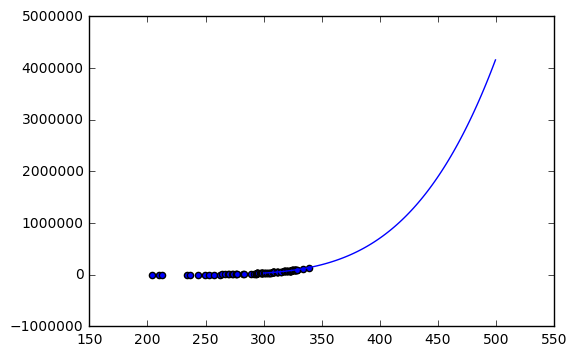

In [34]:
#Criando eixos T e P para plotar a curva de Psat
#T=373
table = np.loadtxt('psat_acet_prog.txt',dtype='float',skiprows=0,usecols=None,unpack=False, ndmin=0)

guessP=10000
Taxis=np.linspace(300,0.983*Tc,100)
Paxis=np.zeros(100)
Paxis[0]=P_sat(Taxis[0],guessP)
for i in range(1,100):
    Paxis[i]=P_sat(Taxis[i],Paxis[i-1])
#    print(Paxis[i])
    
plt.plot(Taxis,Paxis)
plt.scatter(table[:,0],table[:,1]*1000)
plt.show()


In [35]:
#Calculo de Psat com a Equação de Antoine
#OBS: Parâmetros válidos na faixa de 273 a 473K!
#T = 373
def Pantoine(T):
    A = 14.3145
    B = 2756.22
    C = 228.06
    return (np.exp(A - B/(T-273 + C)))*1000
PsatA = Pantoine(T)
print (PsatA)

37862.4778204


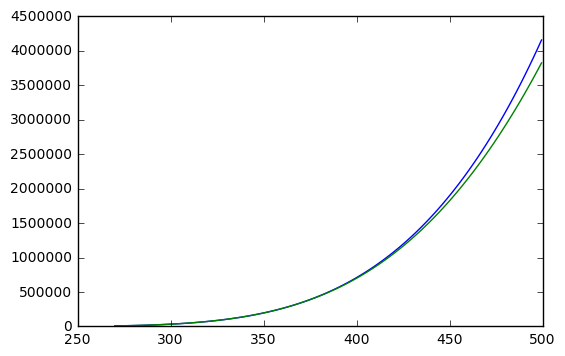

In [36]:
guessP=10000
Taxis=np.linspace(270,0.983*Tc,100) #faixa de validade dos parâmetros de Antoine
Paxis=np.zeros(100)
Paxis[0]=P_sat(Taxis[0],guessP)
for i in range(1,100):
    Paxis[i]=P_sat(Taxis[i],Paxis[i-1])
    
Paxis2=np.zeros(100)
#Paxis2[0]=Pantoine(Taxis[i])
#for i in range(1,100):
Paxis2=Pantoine(Taxis)
    
plt.plot(Taxis,Paxis)
plt.plot(Taxis,Paxis2)
plt.show()
#Peng-Robinson: Azul
#Antoine: verde

In [37]:
#Cálculo de outras propriedades residuais
#Entalpia
def Tr_(T):
    return T/Tc

def H_res(T,P,V):
    return R*T*(Z_(T,P,V) - 1 + (Tr_(T)/(func_alfa_de_T(T))*(k**2-k/(np.sqrt(Tr_(T))) -k**2/np.sqrt(Tr_(T)))-1)*q_(T)*I_(T,P,V))


Vs=V_preos(T,P)
print(Vs)
#print(V_preos(T,P))
print('HL = ',H_res(T,P,Vs[0]))
print('H- = ',H_res(T,P,Vs[1]))
print('HV = ',H_res(T,P,Vs[2]))
print (H_res(T,P,Vs[2]) - H_res(T,P,Vs[0]))
#print (P)
print (T)

[8.4328244629529534e-05, 0.00077579164750315164, 0.024013355159154499]
HL =  -31375.1643188
H- =  -6902.00653217
HV =  -249.870265643
31125.2940531
303


In [38]:
#entropia
def S_res (T,P,V):
    return R*(np.log(Z_(T,P,V)-beta_(T,P))+q_(T)*I_(T,P,V)*(Tr_(T)/(func_alfa_de_T(T))*(k**2-k/(np.sqrt(Tr_(T))) -k**2/np.sqrt(Tr_(T)))))

Vs=V_preos(T,P)
print(Vs)
#print(V_preos(T,P))
print('SL = ',S_res(T,P,Vs[0]))
print('S- = ',S_res(T,P,Vs[1]))
print('SV = ',S_res(T,P,Vs[2]))
print (S_res(T,P,Vs[2]) - S_res(T,P,Vs[0]))

[8.4328244629529534e-05, 0.00077579164750315164, 0.024013355159154499]
SL =  -95.1945018093
S- =  -34.7724090015
SV =  -0.519568729126
94.6749330802


Os valores de referência para comparação com os obtidos pelo modelo foram retirados da base de dados NIST:

http://webbook.nist.gov/cgi/cbook.cgi?ID=C67641&Mask=4&Type=HVAP-FORM2&Plot=on#HVAP-FORM2

O valor obtido nesta temperatura (323K) foi de 30.217KJ/mol , na base de dados se encontra o valor de 29.4975KJ/mol

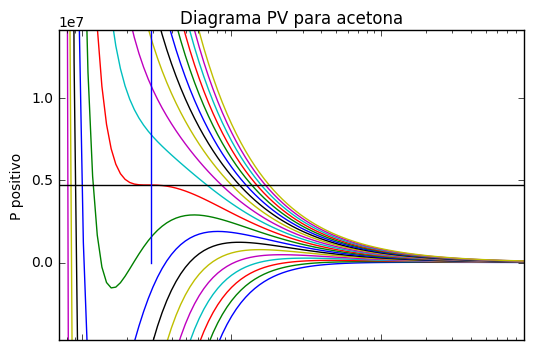

In [23]:
#diagrama PxV para a acetona

for T in np.linspace(.1,2,20)*Tc:
    Vmi = np.exp(np.linspace(np.log(b*1.1),np.log((R*Tc/Pc)*100.),100))
    
    
    #print(Vmi)
    #print(P_preos(T,Vmi))
    
    
    
    plt.figure(1)
    
    #print(Pc,Tc)
    

    
    #print(V_preos(Tc,Pc))
    
    plt.semilogx(Vmi,P_preos(T,Vmi)) 
    plt.ylabel('P positivo') 
    plt.title('Diagrama PV para acetona') 
    
    plt.ylim(-Pc,3*Pc)
    
    plt.xlim(b,(R*Tc/Pc)*100)

    plt.tick_params( 
    axis='x',        
    which='both',    
    bottom='on',     
    top='on',        
    labelbottom='off') 

plt.semilogx([1e-9,1e9],[Pc,Pc])
plt.semilogx([V_preos(Tc,Pc)[2],V_preos(Tc,Pc)[2]],[1e-9,1e9])
    
plt.show()

C:\Users\pdr\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: RuntimeWarning: invalid value encountered in log
C:\Users\pdr\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: RuntimeWarning: invalid value encountered in log
C:\Users\pdr\Anaconda3\lib\site-packages\matplotlib\scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


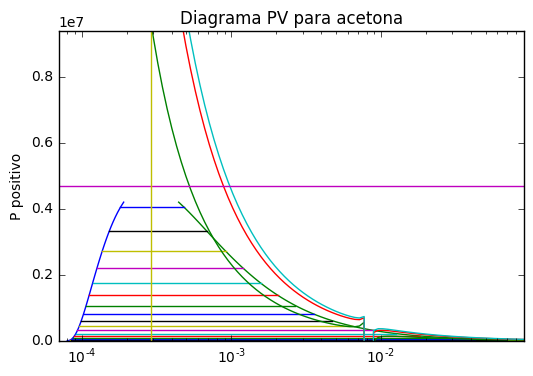

In [44]:
#diagrama PxV para a água

plt.figure(1)

guessP=10000
Taxis=np.linspace(250,Tc,100)
Paxis=np.zeros(100)
VLaxis=np.zeros(100)
VVaxis=np.zeros(100)

Paxis[0]=P_sat(Taxis[0],guessP)
for i in range(1,100):
    Paxis[i]=P_sat(Taxis[i],Paxis[i-1])
    Vs=V_preos(Taxis[i],Paxis[i])
    VLaxis[i]=Vs[0]
    VVaxis[i]=Vs[2]
    



plt.semilogx(VLaxis,Paxis)
plt.semilogx(VVaxis,Paxis)

for i in range(0,100,5):
    plt.semilogx([VLaxis[i],VVaxis[i]],[Paxis[i],Paxis[i]])


for T in np.array([.5,.9,1])*Tc:
    Vmi = np.exp(np.linspace(np.log(b*1.01),np.log((R*Tc/Pc)*100.),100))
    
    
    #print(Vmi)
    #print(P_preos(T,Vmi))
      
    #print(Pc,Tc)
    

    
    #print(V_preos(Tc,Pc))
    
    plt.semilogx(Vmi,P_preos(T,Vmi)) 
    plt.ylabel('P positivo') 
    plt.title('Diagrama PV para acetona') 
    
    plt.ylim(0,2*Pc)
    
    plt.xlim(b,(R*Tc/Pc)*100)

    plt.tick_params( 
    axis='x',        
    which='both',    
    bottom='on',     
    top='on',        
    labelbottom='on') 

plt.semilogx([1e-9,1e9],[Pc,Pc])
plt.semilogx([V_preos(Tc,Pc)[2],V_preos(Tc,Pc)[2]],[1e-9,1e9])
    
plt.show()

In [46]:
#Diagrama ln.PxH

#Coeficientes para calcular Cp
Cp_=np.array([5.126,1.511*10**-3,5.731*10**-5,-7.177*10**-8,2.728*10**-11])

def H_ideal(T):
        Tref=273.15 #Temperatura de referência para cálculo do H ideal (Cp)
        H_ideal=R*(Cp_[4]/5*(T**5-Tref**5)+Cp_[3]/4*(T**4-Tref**4)+Cp_[2]/3*(T**3-Tref**3)+Cp_[1]/2*(T**2-Tref**2)+Cp_[0]*(T-Tref))
        return H_ideal
    
def H_real(T,P,V):
        H_real=H_ideal(T)+H_res(T,P,V)
        return H_real    
print (H_real(T,P,Vs[0]))


nan


C:\Users\pdr\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: RuntimeWarning: invalid value encountered in log


C:\Users\pdr\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: RuntimeWarning: invalid value encountered in log
C:\Users\pdr\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: RuntimeWarning: invalid value encountered in log
C:\Users\pdr\Anaconda3\lib\site-packages\matplotlib\scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


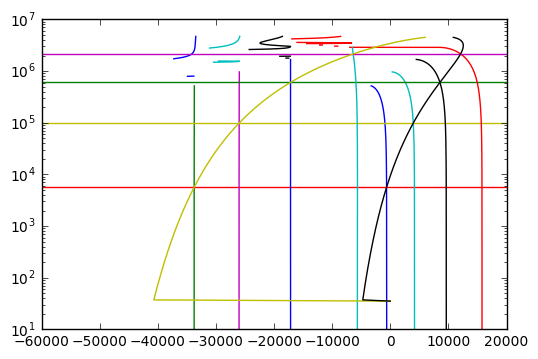

In [48]:
#Gráfico ln(P)xH
T=np.linspace(200,0.9*Tc,5)
Paxis = np.linspace(10,Pc,600)
HL = np.zeros(600)
HM = np.zeros(600)
HV = np.zeros(600)

VL = np.zeros(600)
VM = np.zeros(600)
VV = np.zeros(600)
for j in range (1,5):

#    Vs = V_preos(T,P_sat(T,10000))
#    VL_sat = Vs[0]
#    VV_sat = Vs[2]
#    print(Vs,VL_sat,VV_sat)
    for i in range(0,600):

        Vs = V_preos(T[j],Paxis[i])
#        if (np.count_nonzero(Vs) == 3):
        VL[i] = Vs[0]
        VM[i] = Vs[1]
        VV[i] = Vs[2]
#        else:
#            if(Vs[2]>=VV_sat):
#                print(Vs[2],VV_sat,'vapor')
#                VL[i] = 0
#                VM[i] = 0
#                VV[i] = Vs[2]
#            elif(Vs[2]<=VL_sat):
#                print(Vs[2],VL_sat,'liq')
#                VL[i] = Vs[2]
#                VM[i] = 0
#                VV[i] = 0


        HL[i] = H_real(T[j],Paxis[i],Vs[2])
        HM[i] = H_real(T[j],Paxis[i],Vs[1])
        HV[i] = H_real(T[j],Paxis[i],Vs[0])
     
#plt.semilogx(Vmi,P_preos(T,Vmi))
#plt.semilogx(VL,Paxis)
#plt.semilogx(VM,Paxis)
#plt.semilogx(VV,Paxis)
#plt.semilogx([1e-5,1e-1],[10**4,10**4])
#plt.semilogx([1e-5,1e-1],[Pc,Pc])
    plt.semilogy(HL,Paxis,label=str(T[j]))
#    plt.semilogy(HM,Paxis,label=str(T[j]))
    plt.semilogy(HV,Paxis,label=str(T[j]))
    plt.semilogy([-60000,20000],[P_sat(T[j],1e4),P_sat(T[j],1e4)])
#print(VL)
#print(VM)
#print(VV)

HLaxis=np.zeros(600)
HVaxis=np.zeros(600)
Taxis = np.linspace(200,Tc,600)
Paxis[0]=P_sat(Taxis[0],guessP)
for i in range(1,600):
    Paxis[i]=P_sat(Taxis[i],Paxis[i-1])
    Vs=V_preos(Taxis[i],Paxis[i])
    HLaxis[i]=H_real(Taxis[i],Paxis[i],Vs[0])
    HVaxis[i]=H_real(Taxis[i],Paxis[i],Vs[2])

plt.semilogy(HLaxis,Paxis)
plt.semilogy(HVaxis,Paxis)


#plt.semilogx([b,b],[-0.5e7,4e7])
    
#plt.ylim(-0.5e7,2*Pc)
    
#for T in np.array([590,600,607.5]):
    #for V in np.linspace (0.1*Vs[0],10*Vs[2],100):
        #Haxis[i,:],_= H_real(T,P,V)
        
    #Hl=Haxis[:,2]
    #Hm=Haxis[:,1]
    #Hv=Haxis[:,0]

    
#    plt.figure(1) 
#    plt.semilogy(Hl,Paxis,'r',Hm,Paxis,'g--',Hv,Paxis,'b') 
#    plt.ylabel('log (P)') 
#    plt.xlabel('H')
#    plt.title('Diagrama log(P)xH para água')
#plt.legend()    
plt.show()    

In [50]:
#diagrama TxS
def S_ideal(T,P):
        Pref=1*10**5 #Pa
        Tref=273.15 #K
        S_ideal=R*(Cp_[4]/4*(T**4-Tref**4)+Cp_[3]/3*(T**3-Tref**3)+Cp_[2]/2*(T**2-Tref**2)+Cp_[1]*(T-Tref)+Cp_[0]*np.log(T/Tref))-R*np.log(P/Pref)    
        return S_ideal

def S_real(T,P,V):
        S_real=S_ideal(T,P)+S_res(T,P,V)    
        return S_real

In [52]:
def Tantoine(P):
    A = 14.3145
    B = 2756.22
    C = 228.06
    return (C + B/(A-np.log(P)))
TsatA = Tantoine(P)


In [55]:
Taxis=np.linspace(200,2*Tc,600)
P = np.linspace(1e5,Pc,5)
SL = np.zeros(600)
SM = np.zeros(600)
SV = np.zeros(600)

VL = np.zeros(600)
VM = np.zeros(600)
VV = np.zeros(600)

for j in range (1,5):
    for i in range (0,600):
        Vs = V_preos(Taxis[i],P[j])
        VL[i] = Vs[0]
        VM[i] = Vs[1]
        VV[i] = Vs[2]
        
        SL[i] = S_real(Taxis[i],P[j],Vs[2])
        SM[i] = S_real(Taxis[i],P[j],Vs[1])
        SV[i] = S_real(Taxis[i],P[j],Vs[0])
        
    plt.plot(SL,Taxis,label=str(P[j]))
    plt.ylim(-100,800)
    plt.plot(SV,Taxis,label=str(P[j]))
    plt.plot([-60,10],[Tantoine(P[j]),Tantoine(P[j])])
    
    
SLaxis=np.zeros(600)
SVaxis=np.zeros(600)

P = np.linspace(1e5,Pc,5)
Taxis[0]=Tantoine(P)
for i in range(1,600):
    Taxis[i]=Tantoine(P[i])
    Vs=V_preos(Taxis[i],P[i])
    SLaxis[i]=S_real(Taxis[i],P[i],Vs[0])
    SVaxis[i]=S_real(Taxis[i],P[i],Vs[2])

plt.semilogy(SLaxis,Taxis)
plt.semilogy(SVaxis,Taxis)

C:\Users\pdr\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()
C:\Users\pdr\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: RuntimeWarning: invalid value encountered in log


ValueError: setting an array element with a sequence.